# LAB06 Assigment




### Exercise 1 Linear Discriminant Analysis from Scratch using numpy (50 points )
- <font size=4> Complete the missing code in the LDA class below<font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt


class LDA:
    #n_components:Number of components (<= min(n_classes - 1, n_features)) for dimensionality reduction.
    def __init__(self, n_components=None):
        
        self.n_components = n_components
        self.eigenvalues = None
        self.eigenvectors = None

    def fit(self, X, y):
        if self.n_components is None or self.n_components > X.shape[1]:
            n_components = X.shape[1]
        else:
            n_components = self.n_components
       
        n_features = np.shape(X)[1]
        labels = np.unique(y)
  
        # Within class scatter matrix
        # Complete code for calculating S_W
        ########### Write Your Code Here ###########
        S_W = np.zeros((n_features, n_features))
        for label in labels:
            class_sc_mat = np.zeros((n_features, n_features))
            for row in X[y == label]:
                row, mv = row.reshape(n_features, 1), np.mean(X[y == label], axis=0).reshape(n_features, 1)
                class_sc_mat += (row - mv).dot((row - mv).T)
            S_W += class_sc_mat

        # Between class scatter matrix
        # Complete code for calculating S_B
        ########### Write Your Code Here ###########
        S_B = np.zeros((n_features, n_features))
        mv = np.mean(X, axis=0).reshape(n_features, 1)
        for label in labels:
            n = X[y == label, :].shape[0]
            ui = X[y==label, :].mean(axis=0).reshape(n_features, 1)
            S_B += n * (ui - mv).dot((ui - mv).T)
      
        # Determine SW^-1 * SB by calculating inverse of SW
        ########### Write Your Code Here ###########
        SW_inv = np.linalg.inv(S_W)
        SW_inv_SB = SW_inv.dot(S_B)

        # Get eigenvalues and eigenvectors of SW^-1 * SB
        ########### Write Your Code Here ###########
        eigenvalues, eigenvectors = np.linalg.eig(SW_inv_SB)

        # Sort the eigenvalues and corresponding eigenvectors from largest
        # to smallest eigenvalue and select the first n_components
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:n_components]
        eigenvectors = eigenvectors[:, idx][:, :n_components]
  
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors
  
    def fit_transform(self, X, y):
        ########### Write Your Code Here ###########
        self.fit(X, y)
        return self.transform(X)
  
    def transform(self, X):
        ########### Write Your Code Here ###########
        return np.dot(X, self.eigenvectors) 

- <font size=4> Dimensionality reduction visualization<font>

/var/folders/3w/qtg04t7j5798r10qlyrwnl2m0000gn/T/ipykernel_60525/2010495300.py:32: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_ticklabels([])
/var/folders/3w/qtg04t7j5798r10qlyrwnl2m0000gn/T/ipykernel_60525/2010495300.py:33: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_ticklabels([])
/var/folders/3w/qtg04t7j5798r10qlyrwnl2m0000gn/T/ipykernel_60525/2010495300.py:34: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_ticklabels([])
/var/folders/3w/qtg04t7j5798r10qlyrwnl2m0000gn/T/ipykernel_60525/2010495300.py:40: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


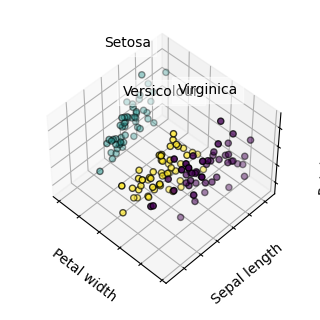

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

np.random.seed(5)


iris = datasets.load_iris()
X = iris.data
y = iris.target
pca = LDA(n_components=3)
pca.fit(X, y)
X = pca.transform(X)

fig = plt.figure(1, figsize=(4, 3))
ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])
for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:    
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean(),
        X[y == label, 2].mean() + 2,
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, 
        edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
# ax.set_title("Ground Truth")
ax.dist = 12

plt.show()

### Exercise 2 Recognize handwritten numbers with LDA (50 points ). 

Your task in this section is to recognize handwritten numbers, and you can use the linear discriminant analysis model from the Scikit-Learn library to fit, evaluate, and predict them.

<font color='red' size=4>Note that your accuracy in this section will directly determine your score.</font>

### Loading the MNIST Dataset


In [3]:
########### Write Your Code Here ###########
# load minist dataset from file
import gzip
import numpy as np

def load_X(filename):
    # 用gzip打开文件
    with gzip.open(filename, 'rb') as f:
        # 读取魔法数
        magic = int.from_bytes(f.read(4), byteorder='big')
        
        # 读取图像数量
        num_images = int.from_bytes(f.read(4), byteorder='big')
        
        # 读取每张图像的行数和列数
        num_rows = int.from_bytes(f.read(4), byteorder='big')
        num_cols = int.from_bytes(f.read(4), byteorder='big')
        
        # 读取图像数据
        image_data = f.read()

    # 将二进制数据转换为numpy数组
    images = np.frombuffer(image_data, dtype=np.uint8)

    # 重塑数组以匹配图像的大小
    images = images.reshape(num_images, num_rows, num_cols)
    return images

def load_y(filename):
    # 用gzip打开文件
    with gzip.open(filename, 'rb') as f:
        # 读取魔法数
        magic = int.from_bytes(f.read(4), byteorder='big')
        
        # 读取标签数量
        num_labels = int.from_bytes(f.read(4), byteorder='big')
        
        # 读取标签数据
        label_data = f.read()

    # 将二进制数据转换为numpy数组
    labels = np.frombuffer(label_data, dtype=np.uint8)
    return labels
############################################

In [4]:
X_train = load_X('./mnist/train-images-idx3-ubyte.gz')
y_train = load_y('./mnist/train-labels-idx1-ubyte.gz')
X_test = load_X('./mnist/t10k-images-idx3-ubyte.gz')
y_test = load_y('./mnist/t10k-labels-idx1-ubyte.gz')

###  Visualization of MINIST

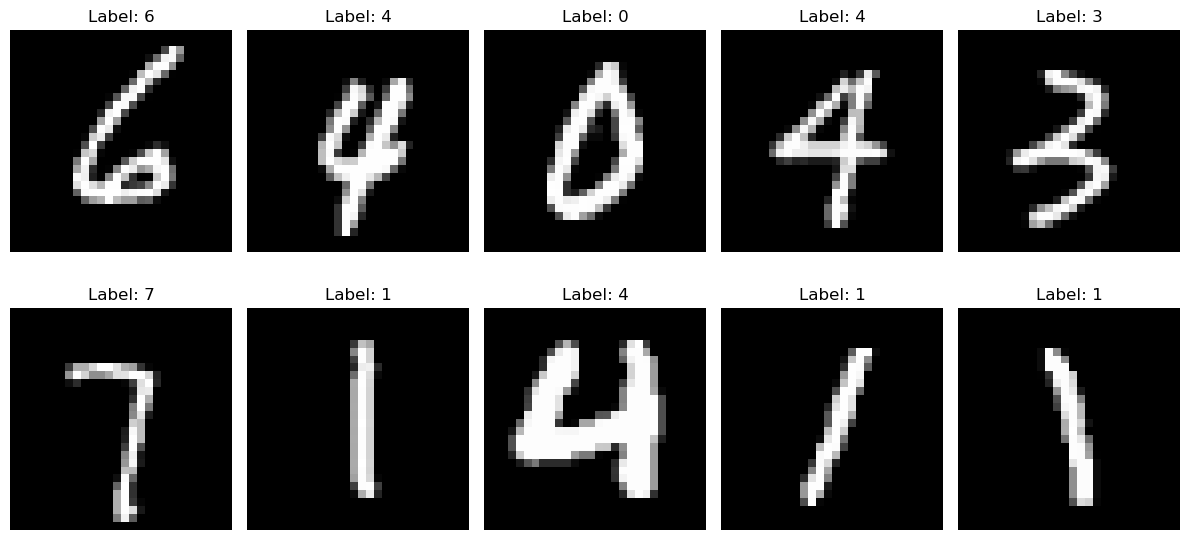

In [5]:
########### Write Your Code Here ###########
import matplotlib.pyplot as plt

# 随机选择并可视化一些图像
num_samples = 10
random_indices = np.random.randint(0, 60000, num_samples)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

############################################

In [6]:
import matplotlib.pyplot as plt

def plot_figure(X, y):
    plt.figure(figsize=(12, 6))
    for i, label in enumerate(np.unique(y)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[y == label][0], cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

### Fit  Model

In [8]:
########### Write Your Code Here ###########
# benchmark
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# 将图像数据转换为一维数组
X_train_reshaped = X_train.reshape(len(X_train), -1)
X_test_reshaped = X_test.reshape(len(X_test), -1)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_reshaped, y_train)

y_pred = lda.predict(X_test_reshaped)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
############################################

Accuracy: 87.30%


In [17]:
########### Write Your Code Here ###########
# benchmark
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# 将图像数据转换为一维数组
X_train_reshaped = X_train.reshape(len(X_train), -1)
X_test_reshaped = X_test.reshape(len(X_test), -1)
lda = LinearDiscriminantAnalysis(n_components=1, solver='lsqr', shrinkage=0.4)
lda.fit(X_train_reshaped, y_train)

y_pred = lda.predict(X_test_reshaped)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
############################################

Accuracy: 87.99%


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 定义超参数网格
param_grid = {
    'n_components': [1, 2, 3, 4],  # 指定成分数量
    'solver': ['lsqr', 'eigen', 'svd'],  # 指定求解器
    'shrinkage': [None, 'auto', 0.1],  # 正则化参数
}

# 创建LDA模型
lda = LinearDiscriminantAnalysis()

# 创建GridSearchCV对象
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(lda, param_grid, cv=cv)  # 使用5折交叉验证

# 使用训练数据拟合GridSearchCV
grid_search.fit(X_train_reshaped, y_train)  # X_train是训练数据，y_train是训练标签

# 打印最佳超参数组合
print("Best parameters found: ", grid_search.best_params_)

# 打印最佳交叉验证分数
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

KeyboardInterrupt: 

## Evaluate model

In [11]:
########### Write Your Code Here ###########
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 定义超参数网格
param_grid = {
    'solver': ['lsqr', 'eigen', 'svd'],  # 指定求解器
}

# 创建LDA模型
lda = LinearDiscriminantAnalysis()

# 创建GridSearchCV对象
grid_search = GridSearchCV(lda, param_grid, cv=5)  # 使用5折交叉验证

# 使用训练数据拟合GridSearchCV
grid_search.fit(X_train_reshaped, y_train)  # X_train是训练数据，y_train是训练标签

# 打印最佳超参数组合
print("Best parameters found: ", grid_search.best_params_)

# 打印最佳交叉验证分数
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
############################################

/Users/zhousicheng/opt/miniconda3/envs/ML_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhousicheng/opt/miniconda3/envs/ML_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhousicheng/opt/miniconda3/envs/ML_env/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/zhousicheng/opt/miniconda3/envs/ML_env/lib/python3.10/site-p

Best parameters found:  {'solver': 'lsqr'}
Best cross-validation score: 0.86


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 定义超参数网格
param_grid = {
    'n_components': [1, 2, 3, 4],  # 指定成分数量
}

# 创建LDA模型
lda = LinearDiscriminantAnalysis(solver='lsqr')

# 创建GridSearchCV对象
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(lda, param_grid, cv=cv)  # 使用5折交叉验证

# 使用训练数据拟合GridSearchCV
grid_search.fit(X_train_reshaped, y_train)  # X_train是训练数据，y_train是训练标签

# 打印最佳超参数组合
print("Best parameters found: ", grid_search.best_params_)

# 打印最佳交叉验证分数
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters found:  {'n_components': 1}
Best cross-validation score: 0.86


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from numpy import arange

# 定义超参数网格
param_grid = {
    'shrinkage': arange(0.1, 0.5, 0.02),  # 正则化参数
}

# 创建LDA模型
lda = LinearDiscriminantAnalysis(solver='lsqr', n_components=1)

# 创建GridSearchCV对象
grid_search = GridSearchCV(lda, param_grid, cv=cv)  # 使用5折交叉验证

# 使用训练数据拟合GridSearchCV
grid_search.fit(X_train_reshaped, y_train)  # X_train是训练数据，y_train是训练标签

# 打印最佳超参数组合
print("Best parameters found: ", grid_search.best_params_)

# 打印最佳交叉验证分数
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

KeyboardInterrupt: 

### Exercise 3: Qustions
- Q1:What are the advantages and disadvantages of LDA?


- Q2 LDA can be used for dimensionality reduction, so can PCA. Please tell the difference between them?